In [1]:
import functions as mf
import functions_axis_symmetric as mfa
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp
import scipy.sparse.linalg as la
from scipy.special import lambertw

import importlib
importlib.reload(mf)
importlib.reload(mfa)

<module 'functions_axis_symmetric' from 'c:\\Users\\brent\\Documents\\comp_multphase_flow\\functions_axis_symmetric.py'>

In [48]:
rho_plasma = 1003 #  kg/m3
mu_plasma = 1e-3 # kg/ms

rho_RBC = 1096 # kg/m3
diameter_RBC = 8e-6 # m
volume_fraction_RBC = 0.1

y_end = 5e-3 # m
Ny = 1000
angle = 0#np.pi / 2

boundary_condition = [1, 1] 
blood_flow_rate = 20e-3 # m/s  # moet gecheckt worden
Q_des = 185*1e-6 #m3/s total bloodflow
pressure_difference = 1e-3
pressure_boundary = np.array([1, 1])*1e-3
system = mf.Multiflow(Ny, y_end, rho_plasma, pressure_difference,
                      pressure_boundary, boundary_condition, mu_plasma, angle)
mu = system.calc_mu(mu_plasma)


def reloadsystem():
    importlib.reload(mf)
    system = mf.Multiflow(Ny, y_end, rho_plasma, pressure_difference,
                      pressure_boundary, boundary_condition, mu_plasma, angle)
    return system


# Plan van aanpak
1D model
1. define system parameters
2. solve laminar
3. solve prantdl in while loop
4. solve wall function in while loop
5. solve alpha2
6. solve velocity u

46
0.00018504250400735528 0.000185


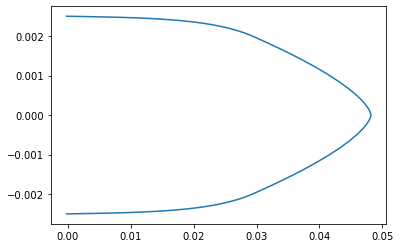

In [41]:
# Prescribed flow rate
system = reloadsystem()
# Q_des = np.pi * (system.y_end/2)**2 * blood_flow_rate
eps = 1e-3
error = 1
system.set_pressure_difference(pressure_difference)

velocity = system.simulate(mu)
Q = np.trapz(velocity, x=system.y)
factor = 0.95
#P = [system.pressure_difference, 2*system.pressure_difference]
switch = [0,0]

while error > eps:
# for i in range(1):
    if switch[-2] != switch[-1]:
        factor*=0.9
    if Q<Q_des:
        # system.pressure_difference = P[-1] + np.abs(P[-1]-P[-2])/2 * factor
        system.pressure_difference += system.pressure_difference * factor

        velocity = system.simulate(mu)
        Q = np.trapz(velocity, x=system.y)
        error = np.abs((Q-Q_des)/Q_des)
        switch.append(0)
        # P.append(system.pressure_difference)
    else:
        # system.pressure_difference = P[-1] - np.abs(P[-1]-P[-2])/2 * fac
        system.pressure_difference -= system.pressure_difference * factor
        velocity = system.simulate(mu)
        Q = np.trapz(velocity, x=system.y)
        error = np.abs((Q-Q_des)/Q_des)
        # P.append(system.pressure_difference)
        switch.append(1)
    if len(switch) == 300:
        print("Oh nyo, it's bwoken")
        break

velocity_laminar = velocity
mu_laminar = mu

print(len(switch))
plt.plot(velocity, system.y)
print(Q, Q_des)

# Brentl mixing length

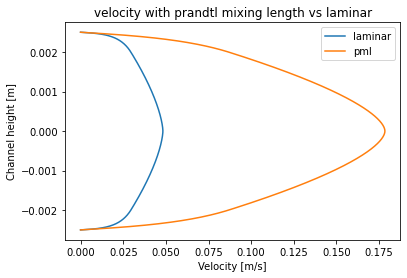

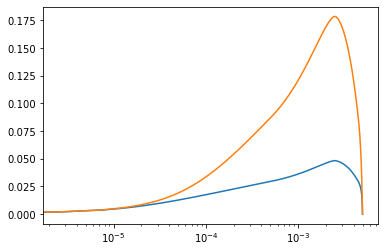

In [42]:
argument_type = None

velocity_new = velocity_laminar

# Then calculate the solution with Prandtl mixing length
eps = 0.01
error = 1
i = 0

# Looping till solution converges
while error > eps:
    velocity = velocity_new

    # Calculate new effective viscosity
    mu_Prandtl = system.calc_mu_Prandtl(velocity, argument_type)

    # Calculate ensuing velocity
    velocity_new = system.simulate(mu_Prandtl)

    error = np.sum(np.abs((velocity_new - velocity) / velocity))
    i+=1
    print("iteration", i, "with error", error, end='\r')

    if i > 2000:
        print("Oh nyo, it's bwoken")
        break

velocity_turbulent = velocity_new
mu_turbulent = mu_Prandtl

plt.plot(velocity_laminar, system.y, label="laminar")
plt.plot(velocity_turbulent, system.y, label="pml")
plt.title("velocity with prandtl mixing length vs laminar")
plt.xlabel('Velocity [m/s]')
plt.ylabel('Channel height [m]')
plt.legend()
plt.show()

# Check for log region
plt.plot(system.y + system.y_end / 2, velocity_laminar)
plt.plot(system.y + system.y_end / 2, velocity_turbulent)
plt.xscale("log")

# Wall functions, two approaches
van dries demping en wall functions bekijken

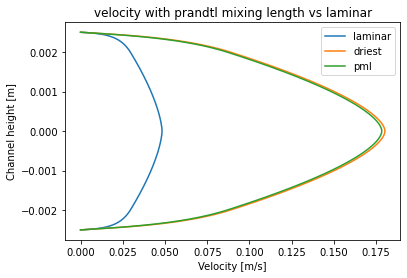

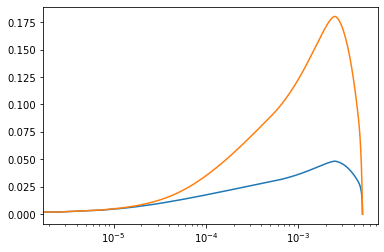

In [43]:
argument_type = "Driest"

velocity_new = velocity_laminar

# Then calculate the solution with Prandtl mixing length
eps = 0.01
error = 1
i = 0

# Looping till solution converges
while error > eps:
    velocity = velocity_new

    # Calculate new effective viscosity
    mu_Prandtl = system.calc_mu_Prandtl(velocity, argument_type)

    # Calculate ensuing velocity
    velocity_new = system.simulate(mu_Prandtl)

    error = np.sum(np.abs((velocity_new - velocity) / velocity))
    i+=1
    print("iteration", i, "with error", error, end='\r')

    if i > 2000:
        print("Oh nyo, it's bwoken")
        break

velocity_Driest = velocity_new
mu_Driest = mu_Prandtl

plt.plot(velocity_laminar, system.y, label="laminar")
plt.plot(velocity_Driest, system.y, label="driest")
plt.plot(velocity_turbulent, system.y, label="pml")

plt.title("velocity with prandtl mixing length vs laminar")
plt.xlabel('Velocity [m/s]')
plt.ylabel('Channel height [m]')
plt.legend()
plt.show()

# Check for log region
plt.plot(system.y + system.y_end / 2, velocity_laminar)
plt.plot(system.y + system.y_end / 2, velocity_Driest)
plt.xscale("log")

In [44]:
"""
# Define constants
kappa = 0.41
E = 9.8
nu = mu_turbulent / system.rho
B = 5.0

# Velocity profile
velocity_new = velocity_turbulent

# First round of calculating variables
u_1 = velocity_new[1]
lamberts_factor = abs(lambertw(u_1 * system.y_wall[1] * kappa * np.exp(kappa * B ) / nu[1]))
u_tau = kappa * u_1 / lamberts_factor
y_plus = system.y_wall * u_tau / nu
print(y_plus[1])

# Define reference tau_w
tau_ref = system.pressure_difference[0] * y_end / 2

error  = 10
epsilon = 1e-7
i=0
while error > epsilon:
  velocity_old = velocity_new
  # Calculate new constant with u_tau != u_1 in log
  u_1 = velocity_new[1]
  lamberts_factor = abs(lambertw(u_1 * system.y_wall[1] * kappa * np.exp(kappa * B ) / nu[1]))
  u_tau = kappa * u_1 / lamberts_factor

  # Calculate tau_w and new constant
  tau_w = system.rho * u_tau**2
  C = tau_w / u_1

  # Velocity shouldn't change on u_1
  velocity_new = system.simulate_wallfunctions(mu_turbulent, C, tau_w)
  
  error = np.abs(np.sum(velocity_new - velocity_old) / np.sum(velocity_old))
  i+=1
  print("iteration", i, "with error", error, end='\r')

print(i)
plt.plot(velocity_new[1:-1])
plt.plot(velocity_turbulent[1:-1])
plt.show()
plt.plot(velocity_new - velocity_turbulent)
"""
"hey"

'hey'

iteration 8 with error 4.216099655610617e-06


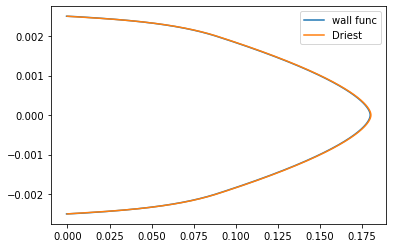

In [45]:
# Wall Function Constants 
velocity_new = velocity_turbulent
E = 9.8
kappa = 0.41
ks = 10 * system.nu_0

i = 0
error = 1
epsilon = 1e-5
while error > epsilon:
    velocity = velocity_new

    # Calculate the new y_plus
    tau_wall = velocity[1] / system.y_wall[1]
    u_tau = np.sqrt(tau_wall / system.rho)
    nu_0 = (mu_turbulent / system.rho)
    y_plus = system.y_wall * u_tau / nu_0

    # Calculate new wall roughness
    ks_plus = u_tau * ks / nu_0[1]
    wall_roughness = 32.6 / ks_plus

    
    # Add new nu for at wall
    nu_plus = np.zeros(system.Ny+2)
    mask = (y_plus < 11.25) * (y_plus > 0)
    nu_plus[mask] = nu_0[mask] * (y_plus[mask] * kappa / np.log(wall_roughness * y_plus[mask]) - 1)
    nu = nu_0 + nu_plus
    mu = nu * system.rho

    # Calculate new velocity
    velocity_new = system.simulate(mu)

    # Error difference in old and new velocity
    error = np.sum(np.abs((velocity_new - velocity) / velocity))
    i+=1
    # print("iteration", i, "with error", error, end='\r')

    if i > 200:
        print("Oh nyo, it's bwoken")
        break

print("iteration", i, "with error", error, end='\n')
plt.plot(velocity_new, system.y, label="wall func")
plt.plot(velocity_Driest, system.y, label="Driest")
plt.legend()
plt.show()

# Euler-euler

c:\Users\brent\Documents\comp_multphase_flow\functions.py:308: RuntimeWarning: divide by zero encountered in true_divide
  velocity_particles_new = velocity_plasma[1:-1] - (1 / (18 * alpha_particles[1:-1] * f_particle * self.nu_0 / self.particle_D**2)) * \
c:\Users\brent\Documents\comp_multphase_flow\functions.py:308: RuntimeWarning: invalid value encountered in multiply
  velocity_particles_new = velocity_plasma[1:-1] - (1 / (18 * alpha_particles[1:-1] * f_particle * self.nu_0 / self.particle_D**2)) * \


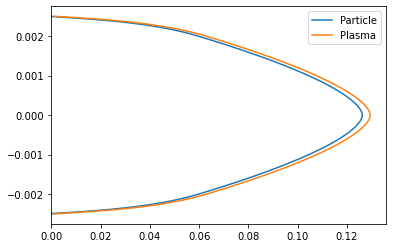

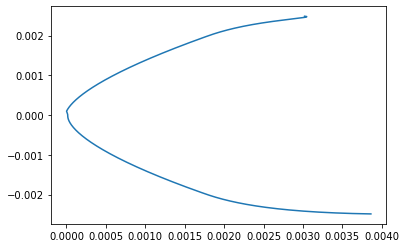

In [63]:
# Add particles to the system
system = reloadsystem()
system.add_particles(rho_RBC, diameter_RBC, volume_fraction_RBC)


# calculate initial alpha of the particles
alpha_particles = system.calc_alpha(velocity_turbulent, mu_turbulent)

# Calculate volumetric plasma concentration
alpha_fluid = 1 - alpha_particles
velocity_new = velocity_turbulent

# While loop to iterate of velocity
i = 0
error = 1
epsilon = 1e-3
while error > epsilon:
    velocity = velocity_new

    # Calculate new velocity
    velocity_new = system.simulate_with_particles(mu_turbulent, alpha_fluid)

    # Error difference in old and new velocity
    error = np.sum(np.abs((velocity_new - velocity) / velocity))
    alpha_particles = system.calc_alpha(velocity_turbulent, mu_turbulent)

    # Calculate volumetric plasma concentration
    alpha_fluid = 1 - alpha_particles
    i+=1

    if i > 200:
        print("Oh nyo, it's bwoken")
        break


velocity_plasma = velocity_new
velocity_particle = system.solve_particle_velocity(alpha_particles, velocity_plasma, mu_turbulent)

plt.plot(velocity_particle, system.y[1:-1],label="Particle")
plt.plot(velocity_plasma[1:-1], system.y[1:-1], label="Plasma")
plt.xlim(0)
plt.legend()
plt.show()
alpha_particles[alpha_particles != 0] = np.abs(alpha_particles[alpha_particles != 0] -0.1004)
plt.plot(alpha_particles[alpha_particles != 0], system.y[alpha_particles != 0])
plt.show()

[0. 0. 0. ... 0. 0. 0.]


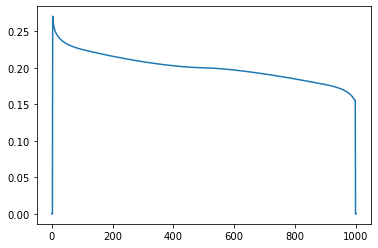

In [21]:
print(alpha_particles)
plt.plot(alpha_particles)

## Axis symmetric
(z, r)

In [39]:
def reloadsystem():
    importlib.reload(mf)
    system = mf.Multiflow(
        Nr, r_end, rho_fluid, pressure_difference,
        pressure_boundary, boundary_condition, mu_fluid[:,0], angle
    )
    
    return system

def reload_system_axis():
    importlib.reload(mfa)
    system_axis = mfa.MultiFlowAxis(Nz, Nr, z_end, r_end, rho_fluid, mu_fluid, inlet)
    system_axis.make_boundary_conditions()
    return system_axis

rho_fluid = 1000
z_end = 10
Nz = 5
r_end = 1
Nr = 3
mu_fluid = 1e-3 * np.ones((Nr+2, Nz+2))
pressure = np.zeros((Nr+2, Nz+2))

# 1D solution used for inlet
rho_plasma = 1003 #  kg/m3
mu_plasma = 1e-3 # kg/ms

rho_RBC = 1096 # kg/m3
diameter_RBC = 8e-6 # m
volume_fraction_RBC = 0.2

angle = 0 #np.pi / 2

boundary_condition = [-1, 1] 
blood_flow_rate = 20e-3 # m/s  # moet gecheckt worden
Q_des = 185*1e-6 #m3/s total bloodflow
pressure_difference = 1e-2
pressure_boundary = np.array([1, 1])*1e-3
system = reloadsystem()

inlet = system.simulate(system.mu_0)

system_axis = reload_system_axis()


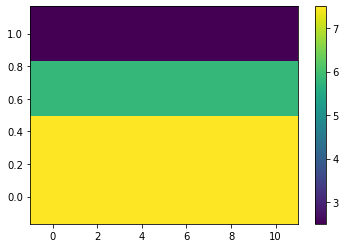

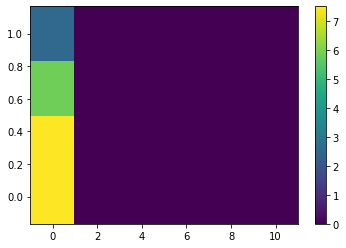

In [40]:
system_axis = reload_system_axis()
# initial velocities
velocity_z = np.repeat([system_axis.inlet], system_axis.Nz + 2, axis=0) # at z-offset points
velocity_z = np.swapaxes(velocity_z, 0, 1)
velocity_r = np.zeros((system_axis.Nr+2, system_axis.Nz + 2)) # at r-offset points

plt.pcolor(system_axis.Z, system_axis.R, velocity_z)#, vmin=-6, vmax=6)
plt.colorbar()
plt.show()

pressure = np.zeros((system_axis.Nr+2, system_axis.Nz+2)) + (system_axis.z_end - system_axis.Z) * pressure_difference

for i in range(1):
    velocity_z = system_axis.solve_velocity_z(velocity_z, velocity_r, mu_fluid, pressure)
    velocity_r = system_axis.solve_velocity_r(velocity_z, velocity_r, mu_fluid, pressure)
   
    plt.pcolor(system_axis.Z, system_axis.R, velocity_z)#, vmin=-6, vmax=6)
    plt.colorbar()
    plt.show()



In [44]:
system_axis = reload_system_axis()
# SIMPLE ALGORITHM
relaxation_factor = 0.2
epsilon = 1e-3
error = 1
i=0

velocity_z = np.repeat([system_axis.inlet],system_axis.Nz + 2, axis=0) # at z-offset points
velocity_z = np.swapaxes(velocity_z, 0, 1)
velocity_r = np.zeros((system_axis.Nr+2, system_axis.Nz+2)) # at r-offset points


# plt.pcolor(system_axis.Z, system_axis.R, velocity_z)#, vmin=-6, vmax=6)
# plt.colorbar()
# plt.show()

pressure = np.zeros((system_axis.Nr+2, system_axis.Nz+2)) + (system_axis.z_end - system_axis.Z) * pressure_difference

# plt.matshow(pressure)
# plt.colorbar()
# plt.show()


# while error > epsilon:
for i in range(5):
    i+=1
    # 1. initial guess for velocities, pressure
    vel_old_z = velocity_z
    vel_old_r = velocity_r
    p_old = pressure

    # 2. solve the momentum equations using guesses
    velocity_z_star = system_axis.solve_velocity_z(vel_old_z, vel_old_r, mu_fluid, pressure)
    velocity_r_star = system_axis.solve_velocity_r(vel_old_z, vel_old_r, mu_fluid, pressure)
    # plt.matshow(velocity_z)
    # plt.show()
    # 3. solve pressure using velocity from momentum eq
    pressure_corrector = system_axis.pressure_correction(velocity_z_star, velocity_r_star, mu_fluid)
    plt.matshow(pressure_corrector)
    plt.colorbar()
    plt.show()
    
    # 4. correct pressure and velocities
    pressure = p_old + pressure_corrector * relaxation_factor
    velocity_z, velocity_r = system_axis.velocity_corrections(
        velocity_z, velocity_r, mu_fluid, pressure_corrector, relaxation_factor, velocity_z_star, velocity_r_star
    )
    # plt.matshow(pressure)
    # plt.colorbar()
    # plt.show()
    # print(np.sum(np.abs(velocity_z - vel_old_z)))
    # print(np.argmax(velocity_z))
    error = np.sum(np.abs((velocity_z - vel_old_z) / vel_old_z))
    print("iteration", i, "with error", error, end='\n')

    if i > 2000:
        print("Oh nyo, it's bwoken")
        break


iteration 1 with error 2.999988823108542
iteration 2 with error 3.6336808539591106
iteration 3 with error 278.2801796215042
iteration 4 with error 7405.441450284607
iteration 5 with error 150.25134937770176
iteration 6 with error 9701.799394954322
iteration 7 with error 819.6909064068445
iteration 8 with error 198.57149455160481
iteration 9 with error 129.29435419991978
iteration 10 with error 88.12391238285284


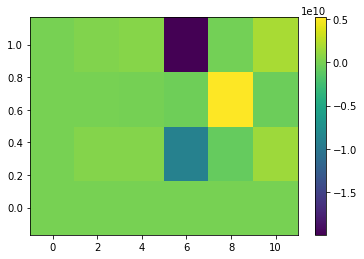

In [45]:
plt.pcolor(system_axis.Z, system_axis.R, velocity_z)#, vmin=-6, vmax=6)
plt.colorbar()
plt.show()

In [26]:
matrix = np.array([[1,0],[1,0]])
np.reshape(np.copy(matrix), newshape=(-1),  order="C")

array([1, 1, 0, 0])

20-30 min presentation
colleages target audience
they don't know about fvm and